# Face cell response simulations

Written July 2022 by CMH

To generate more realistic neural responses that give us acess to the tuning structure of individual neurons, I am trying an alternative approach to simulating neural responses. The steps/logic are as follows: 

1. Do an eigendecomposition on a set of face images to get a set of putative face features to stand in for the types of features observed in Chang & Tsao (2017). 

2. Simulate n IT neurons with randomized weights where each neuron is tuned strongly to a single feature and the tuning to remaining features is randomized to keep a sum of 1.

3. Compute the response of each synthetic neuron as a linear combination of the features for a given image weighted by each neurons feature weight. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance

def rectifying_nonlinearity(resp):
    for i in range(0, len(resp)):
        if resp[i] < 0:
            resp[i] = 0
    return resp

# Step 1: Eigenface production

I use the LFW faces dataset from sklearn to decompose to a set of features for face space.

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=20) # want to maximize number of faces
print(faces.images.shape)


(3023, 62, 47)


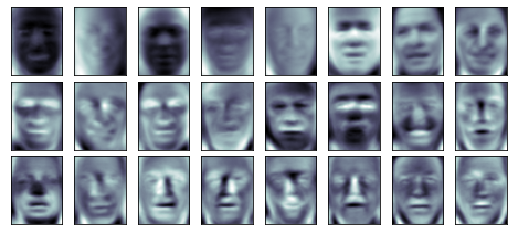

In [3]:
pca = PCA(100, svd_solver='randomized') # bring to 100 components 
pca.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
    
components = pca.transform(faces.data)
print(components[0].shape)

# Step 2: Simulate neurons with random weights tuned primarily to a single feature dimension

Right now I have a weird linear transformation at the end before the rectifying nonlinearity to keep things looking spike count like. Maybe there's a better way to handle this?

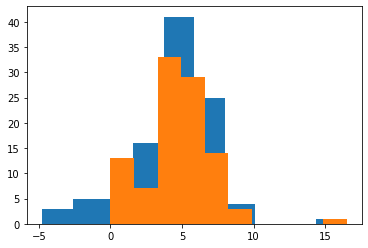

In [108]:
num_neurons = 100;
num_features = 100; # based on 100-dimensional face space in Chang & Tsao

# Simulate random feature weights for each neuron
W = np.empty((num_neurons, num_features))
for i in range(num_neurons):
    principle_feature = np.random.randint(0, num_features) # choose principle feature to encode
    W[i, principle_feature] = np.random.normal(0, 0.08) + 0.85 # tuning of principle feature
    
    # Algorithm to fill remaining weights with what's needed to get to sum of 1
    sum_left = 1 - W[i, principle_feature]
    all_features = np.ones(num_features)
    all_features[principle_feature] = 0
    all_features = np.multiply(all_features, np.arange(num_features)+1)-1 # sets to -1 when not included
    rand_vec = np.random.normal(15, 0.1, (num_features-1,1)) # Generate random vector
    rand_vec = rand_vec / np.linalg.norm(rand_vec, ord=2) # normalize to length 1
    weights = np.multiply(rand_vec, sum_left) # scale to desired length
    
    weight_cnt = 0;
    for j in range(len(all_features)):
        if all_features[j] != -1:
            W[i, j] = weights[weight_cnt]
            weight_cnt += 1
    
test_component = components[0] / np.linalg.norm(components[0], ord=2) # normalize feature vector to length 1
resp_im1 = test_component @ W.T # Predict the response to this image
resp_im1 = (resp_im1 * 40) + 5
h = plt.hist(resp_im1.T)
resp_im1 = rectifying_nonlinearity(resp_im1.reshape(num_neurons,))
h = plt.hist(resp_im1)

# Right now we have to relax a few things like the discrete nature of spike counts



In [116]:
theta = 15
a = test_component
# Rotate vector a by specified number of degrees to generate vector b
rand_vec = np.random.randn(num_features,) # random vector we can orthogonalize wrt original
orth_vec = rand_vec - (((rand_vec.T@a)/(a.T@a))*a) # orthogonalize wrt a

# normalize to unit length
a_norm = a * (1/ np.linalg.norm(a))
orth_vec_norm = orth_vec * (1/ np.linalg.norm(orth_vec))

b = (a_norm * np.cos(np.radians(theta))) + (orth_vec_norm*np.sin(np.radians(theta))) # generate second vector
b = b * np.linalg.norm(a) # scale new vector up to same size as original

resp_a = a @ W.T # Predict the response to this image
resp_a = (resp_a * 40) + 5
resp_a = rectifying_nonlinearity(resp_a.reshape(num_neurons,))
resp_b = b @ W.T # Predict the response to this image
resp_b = (resp_b * 40) + 5
resp_b = rectifying_nonlinearity(resp_b.reshape(num_neurons,))

print(np.degrees(np.arccos(1-distance.cosine(resp_a, resp_b))))


10.42074547168502


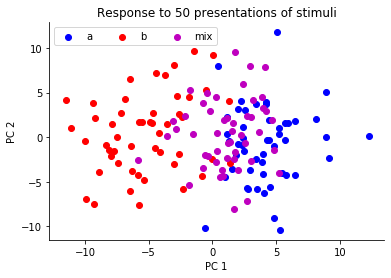

In [117]:
# Simulate using the poisson model
num_pres = 50 # number of presentations to simulate
prop_maj = 0.75

a = resp_a
b = resp_b

# Simulate response of num_pres presentations of each image and images together
a_draws = np.empty((num_neurons, num_pres))
b_draws = np.empty((num_neurons, num_pres))
mix_draws = np.empty((num_neurons, num_pres))
for i in range(0, num_neurons):
    a_draws[i, :] = np.random.poisson(lam=a[i], size=(1, num_pres))
    b_draws[i, :] = np.random.poisson(lam=b[i], size=(1, num_pres))
    mix_draws[i, :] = (prop_maj * np.random.poisson(lam=a[i], size=(1, num_pres))) + ((1-prop_maj) * np.random.poisson(lam=b[i], size=(1, num_pres))) # mixture model from Car

labels = np.concatenate((np.zeros((1, num_pres)), np.zeros((1, num_pres))+1, np.zeros((1, num_pres))+2), axis=1)
all_resp = np.concatenate((a_draws, b_draws, mix_draws), axis=1)

# Fit PCA model from sklearn
pca = PCA(n_components=2)
pca.fit(all_resp.T)
pc_activations = pca.transform(all_resp.T)

# Plot for visualization
fig, ax = plt.subplots()
c_resp = ['b', 'r', 'm']
f_labels = ['a', 'b', 'mix']

for i in range(0, 3):
    ax.scatter(pc_activations[(labels==i).reshape(num_pres*3,), 0], pc_activations[(labels==i).reshape(num_pres*3,), 1], c=c_resp[i], label=f_labels[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
ax.set_title('Response to %d presentations of stimuli' % num_pres)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=3)
plt.show()


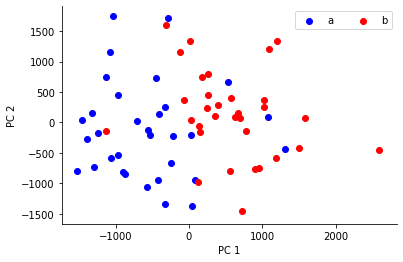

In [119]:
# labels = np.concatenate((np.zeros((1, 32)), np.zeros((1, 32))+1), axis=0)
# all_resp = np.concatenate((a, b), axis=0)

# # Fit PCA model from sklearn
# pca = PCA(n_components=2)
# pca.fit(all_resp)
# pc_activations = pca.transform(all_resp)

# # Plot for visualization
# fig, ax = plt.subplots()
# c_resp = ['b', 'r']
# f_labels = ['a', 'b']

# for i in range(0, 2):
#     ax.scatter(pc_activations[(labels==i).reshape(32*2,), 0], pc_activations[(labels==i).reshape(32*2,), 1], c=c_resp[i], label=f_labels[i])

# ax.set_ylabel('PC 2')
# ax.set_xlabel('PC 1')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.legend(ncol=3)
# plt.show()
